# Project 2 - ML
### Run - Angular Analysis

In [131]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from angle_functions import calculate_angles, train_and_evaluate_model, max_min_angle_per_participant, max_max_min_min_angles, predict_ex_range

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Loading dataset, original one as 'file_1' and relabeled one as 'file_2'.
The relabeled dataset contains for each frame the “Label” column which is either ‘1’ if the subject is in the target pose or ‘0’ if the subject is in another pose (T-pose, …)

In [4]:
# Change the files according to where the .parquet files are in your machine

file_1 = 'All_Relative_Results_Cleaned.parquet'
file_2 = 'All_Relative_Results_CleanedRelabeled.parquet'

data = pd.read_parquet(file_1)
data_relab = pd.read_parquet(file_2)

# Cleaning both datasets

rows_with_nan = data[data.isnull().any(axis=1)]

def percentage_nan_by_row(df):
    return df.isnull().mean(axis=1)*100

percentage_nan_by_rows = percentage_nan_by_row(rows_with_nan.drop(['Participant', 'Set', 'Camera','Exercise', 'time(s)'], axis='columns'))
percentage_nan_by_rows[percentage_nan_by_rows==100].shape

data_cleaned = data.dropna().copy(deep=True)

# same for relabeled file 

rows_with_nan = data[data.isnull().any(axis=1)]

data_cleaned_relab = data_relab.dropna().copy(deep=True)

We compute 6 angles (3 on each side) between joints and store them in 6 columns. We get rid of the other columns containing coordinates to only keep angles data

In [5]:
# Data Frame + calculating 6 angles of position (3 left, 3 right)

df = pd.DataFrame(data_cleaned)

calculate_angles(df)

# Keeping 44 columns of interest : principal detectors

columns_of_interest = ['Participant','Exercise','Set','Camera','time(s)',
                     'angle_left_knee_hip_shoulder','angle_right_knee_hip_shoulder','angle_left_ankle_knee_hip',
                     'angle_right_ankle_knee_hip','angle_left_shoulder_elbow_wrist','angle_right_shoulder_elbow_wrist'
                     ]

df_reduc = df[columns_of_interest]

# Same for relabeled : same 44 columns + 'Label' column

df_relab = pd.DataFrame(data_cleaned_relab)

calculate_angles(df_relab)

columns_of_interest_relab = ['Participant','Exercise', 'Label', 'Set','Camera','time(s)',
                     'angle_left_knee_hip_shoulder','angle_right_knee_hip_shoulder','angle_left_ankle_knee_hip',
                     'angle_right_ankle_knee_hip','angle_left_shoulder_elbow_wrist','angle_right_shoulder_elbow_wrist'
                     ]

df_reduc_relab = df_relab[columns_of_interest_relab]

We only keep the correct set to plot it (otherwise, several curves overlap).
Then we group the dataset by Participant, Camera and Exercise. Finally we plot the body bending angle over time for 1 exercise to see its dynamic.

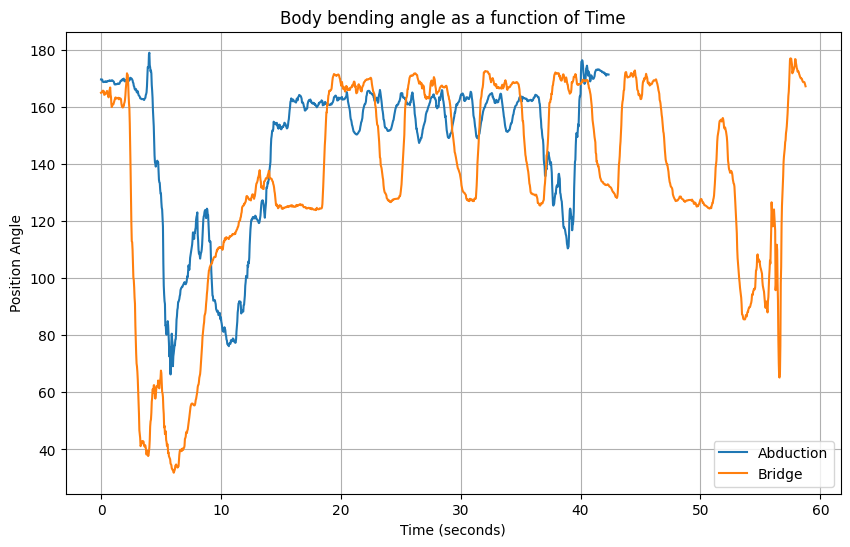

In [17]:
df_corr = df_reduc[df_reduc['Set']=='Correct']

# grouping dataset
grouped_data = df_corr.groupby(['Participant', 'Camera', 'Exercise'])

# isolating 2 different exercises for a single participant to plot it 
p05_frontal_top_abduction = grouped_data.get_group(('P05', 'Frontal_Top', 'Abduction'))
p05_frontal_top_bridge = grouped_data.get_group(('P05', 'Frontal_Top', 'Bridge'))

time_column = 'time(s)'
angle_column = 'angle_left_knee_hip_shoulder'

# Plot the data for P05
plt.figure(figsize=(10, 6))
plt.plot(p05_frontal_top_abduction[time_column], p05_frontal_top_abduction[angle_column], label='Abduction', linestyle='-')
plt.plot(p05_frontal_top_bridge[time_column], p05_frontal_top_bridge[angle_column],label='Bridge', linestyle='-')

# Set plot title and labels
plt.title('Body bending angle as a function of Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Position Angle')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

As we can see on the above plot, there is a lot of motion unrelated to the exercises during begining and end of it as the participant gets in position and finishes the exercise. This can induce a lot of bias into the exercise recognition, as the data does not target only the active part of the exercise. 

### Approach #1

To address this problem, we use the second dataset (the relabeled one) : 

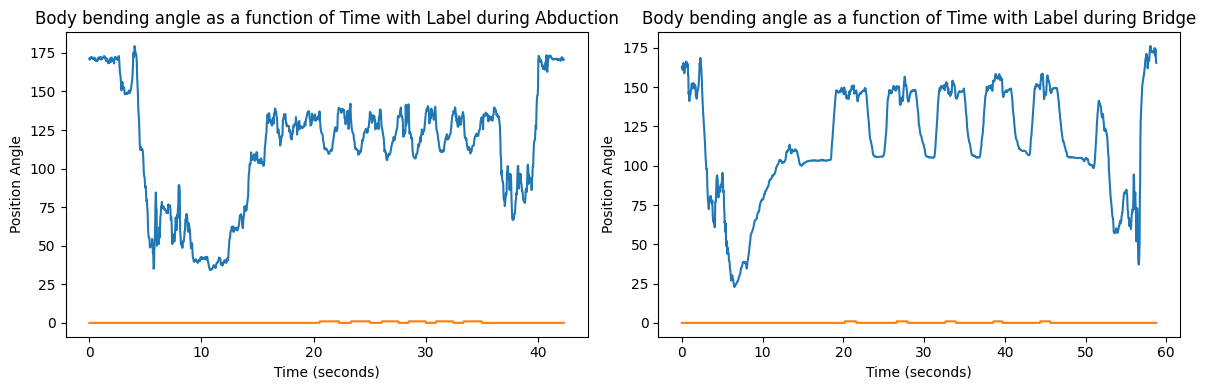

In [18]:
df_corr_relab = df_reduc_relab[df_reduc_relab['Set']=='Correct']

# grouping dataset
grouped_data_relab = df_corr_relab.groupby(['Participant', 'Camera', 'Exercise'])

# isolating abduction exercise for a single participant to plot it 
p05_frontal_top_abduction_relab = grouped_data_relab.get_group(('P05', 'Frontal_Top', 'Abduction'))
p05_frontal_top_bridge_relab = grouped_data_relab.get_group(('P05', 'Frontal_Top', 'Bridge'))

time_column = 'time(s)'
angle_column = 'angle_left_knee_hip_shoulder'
label_column = 'Label'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the values in the first subplot
axes[0].plot(p05_frontal_top_abduction_relab[time_column], p05_frontal_top_abduction_relab[angle_column], label='Abduction', linestyle='-')
axes[0].plot(p05_frontal_top_abduction_relab[time_column], p05_frontal_top_abduction_relab[label_column], label='Label', linestyle='-')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Position Angle')
axes[0].set_title('Body bending angle as a function of Time with Label during Abduction')

# Plot some other values in the second subplot (modify as needed)
axes[1].plot(p05_frontal_top_bridge_relab[time_column], p05_frontal_top_bridge_relab[angle_column], label='Bridge', linestyle='-')
axes[1].plot(p05_frontal_top_bridge_relab[time_column], p05_frontal_top_bridge_relab[label_column], label='Label', linestyle='-')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Position Angle')
axes[1].set_title('Body bending angle as a function of Time with Label during Bridge')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


We can now notice how nicely the '1' Label targets the active part of the exercise and how it can allow us to get rid of unwanted recording before and after the exercise.

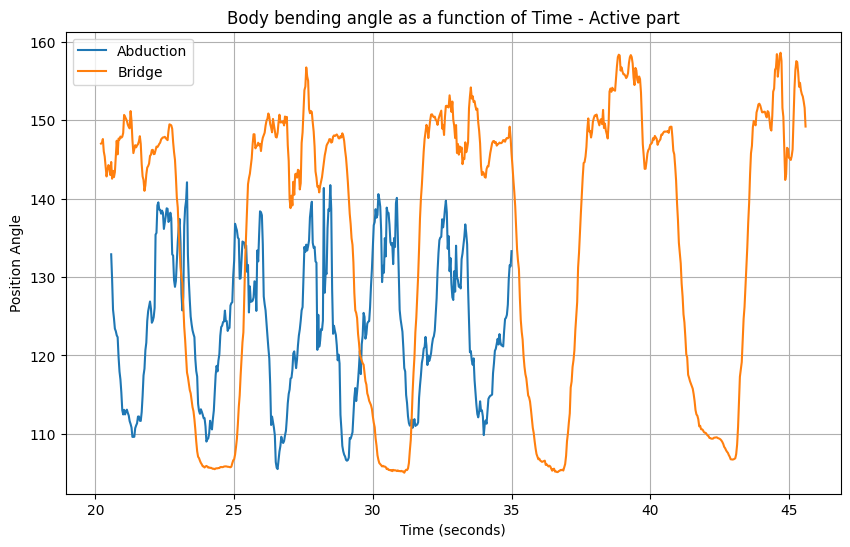

In [20]:
# Find the index of the first occurrence of '1'
first_one_index_abd = p05_frontal_top_abduction_relab[p05_frontal_top_abduction_relab['Label'] == 1].index[0]
first_one_index_bri = p05_frontal_top_bridge_relab[p05_frontal_top_bridge_relab['Label'] == 1].index[0]

# Find the index of the last occurrence of '1'
last_one_index_abd = p05_frontal_top_abduction_relab[p05_frontal_top_abduction_relab['Label'] == 1].index[-1]
last_one_index_bri = p05_frontal_top_bridge_relab[p05_frontal_top_bridge_relab['Label'] == 1].index[-1]


# Get the rows corresponding to the first and last occurrences of '1'
first_one_row_abd = p05_frontal_top_abduction_relab.loc[first_one_index_abd]
first_one_row_bri = p05_frontal_top_bridge_relab.loc[first_one_index_bri]

last_one_row_abd = p05_frontal_top_abduction_relab.loc[last_one_index_abd]
last_one_row_bri = p05_frontal_top_bridge_relab.loc[last_one_index_bri]


subset_abd = p05_frontal_top_abduction_relab.loc[first_one_index_abd:last_one_index_abd]
subset_bri = p05_frontal_top_bridge_relab.loc[first_one_index_bri:last_one_index_bri]

# Plot the data for P05 - Abduction
plt.figure(figsize=(10, 6))
plt.plot(subset_abd[time_column], subset_abd[angle_column], label='Abduction', linestyle='-')
plt.plot(subset_bri[time_column], subset_bri[angle_column], label='Bridge', linestyle='-')

# Set plot title and labels
plt.title('Body bending angle as a function of Time - Active part')
plt.xlabel('Time (seconds)')
plt.ylabel('Position Angle')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

From now on, we will use the relabeled dataset as it proved how effective it was to target the active part of each exercise

In [21]:
# Only keeping '1'-Labeled rows from relabeled dataset 

df_label1 = df_reduc_relab[df_reduc_relab['Label']==1]


In [22]:
df_ = df_label1.drop(['Participant', 'Set', 'Camera'], axis=1) # we get rid of non-numerical data columns 

# Sample columns for joint angles (replace with your actual column names)
angle_columns = ['angle_left_knee_hip_shoulder', 'angle_left_ankle_knee_hip', 'angle_left_shoulder_elbow_wrist',
                  'angle_right_knee_hip_shoulder', 'angle_right_ankle_knee_hip', 'angle_right_shoulder_elbow_wrist']


We now test our model with 3 different classifiers to see which one obtain the best accuracy : 
- Random Forest Classifier
- Support Vector Classifier (SVC)
- Gradient Boosting Classifier

In [24]:
try:
    # Try to unpack the values
    predictions, y_test = train_and_evaluate_model(df_, angle_columns)
except ValueError:
    # Handle the error if too many values to unpack
    pass

RandomForestClassifier Test Accuracy: 94.46%
RandomForestClassifier F1 Score macro: 0.9389
RandomForestClassifier F1 Score micro: 0.9446
SVC Test Accuracy: 93.10%
SVC F1 Score macro: 0.9241
SVC F1 Score micro: 0.9310
GradientBoostingClassifier Test Accuracy: 89.95%
GradientBoostingClassifier F1 Score macro: 0.8898
GradientBoostingClassifier F1 Score micro: 0.8995


RandomForestClassifier


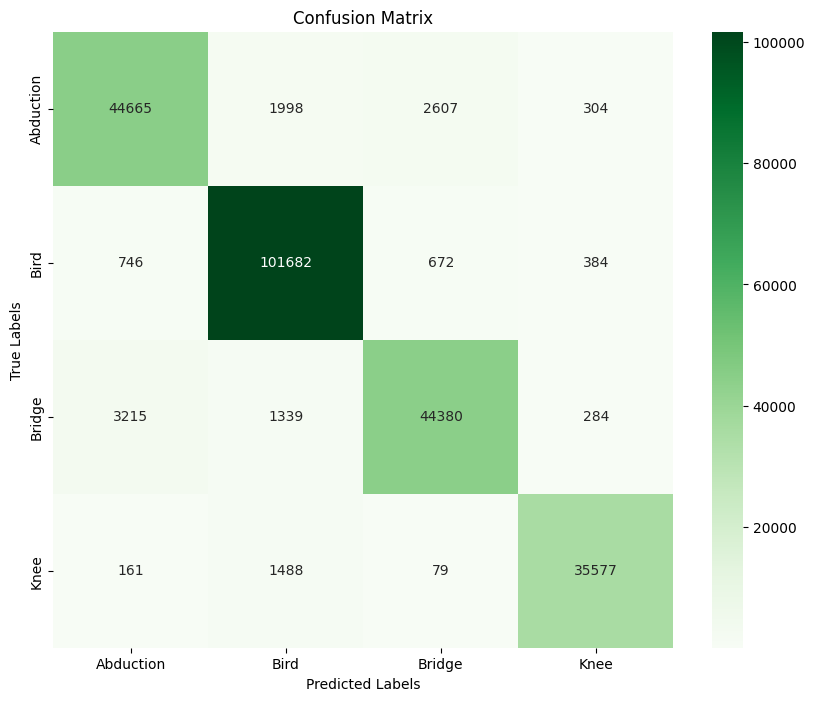

SVC


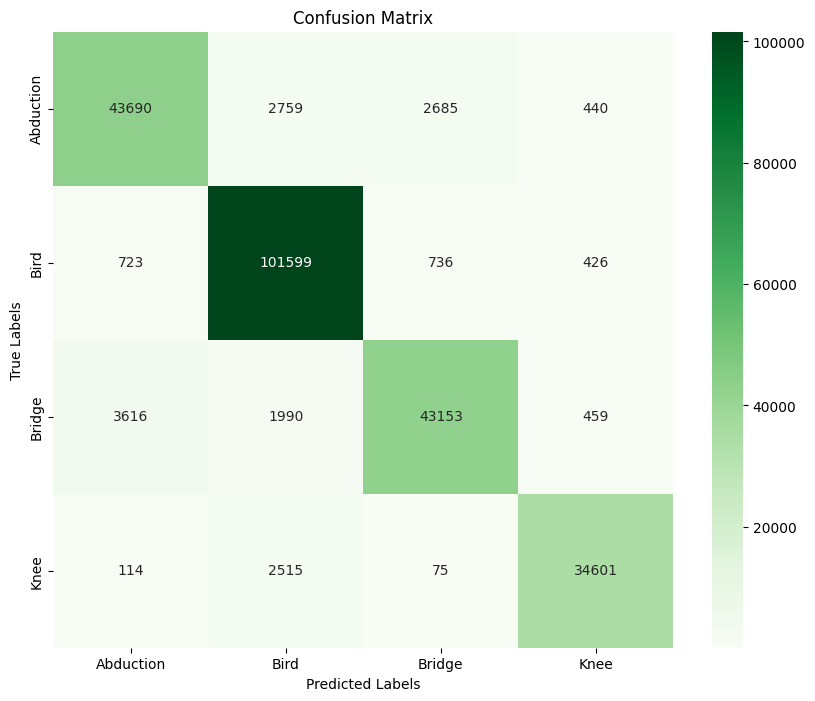

GradientBoostingClassifier


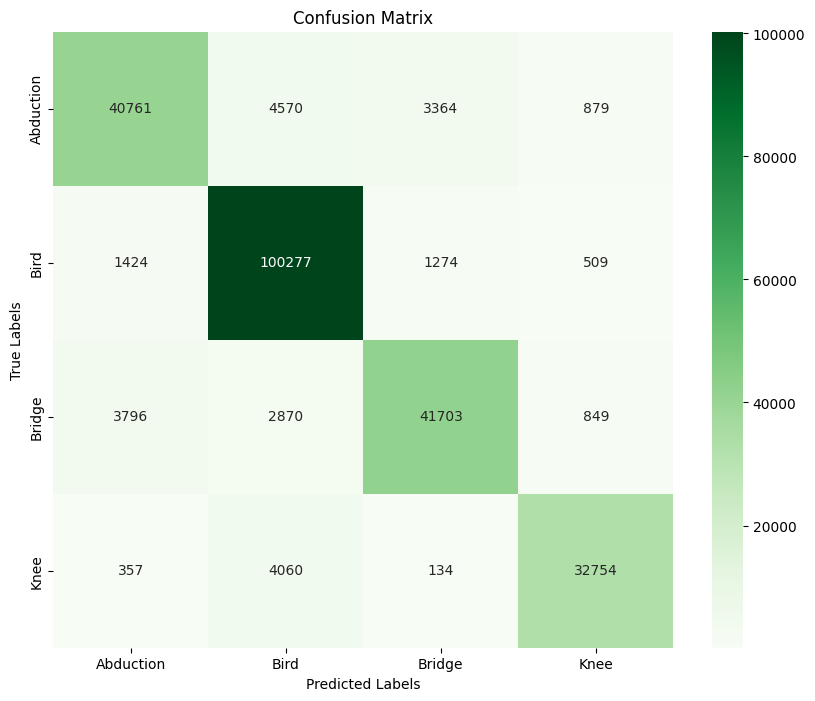

In [26]:
classifiers = ['RandomForestClassifier','SVC','GradientBoostingClassifier']

for method in classifiers :     
    print(method)

    cm = confusion_matrix(y_test, predictions[method])
    unique_exercises = df_['Exercise'].unique()

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=unique_exercises, yticklabels=unique_exercises)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

We can see that all three methods give similar performances, with a small prevalence in term of accuracy for the RF method. Using only 6 dimensions (the 6 computed angles), the accuracy score seems very good despite the small data dimension. These methods may not be  not fully optimized for exercise recognition yet, but it can definitely be a lead for an improved application, for example with a larger number of exercises.

### Approach #2

Instead of using the relabeled dataset, we use the original one but cut the beginning of each exercise to only target the active part : 

In [33]:
# Keeping only data points at timing 50 to 80% of the complete exercise : targets active part of exercise

# Specify the percentage range
percentage_start = 50
percentage_end = 80

# Initialize an empty list to store selected rows for each group
selected_rows = []

# Iterate through each group
for _, group_df in df_corr.groupby(['Exercise', 'Participant', 'Camera']):
    # Calculate the time thresholds based on the specified percentage range for each group
    time_threshold_start = np.percentile(group_df['time(s)'], percentage_start)
    time_threshold_end = np.percentile(group_df['time(s)'], percentage_end)
    
    # Extract rows within the specified time range for the current group
    group_rows = group_df[(group_df['time(s)'] >= time_threshold_start) & (group_df['time(s)'] <= time_threshold_end)]
    
    # Append the selected rows to the list
    selected_rows.append(group_rows)

# Concatenate the selected rows into a new DataFrame
target_data = pd.concat(selected_rows, ignore_index=True)

We now plot the targeted part of each exercise, here only for the body bending angle, but this could be done the same way for other angles

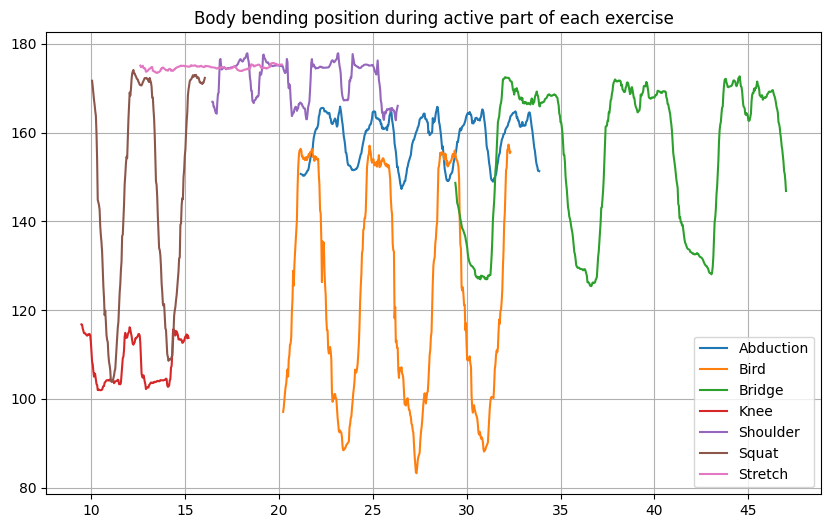

In [29]:
# Plotting bending of the subject during Abduction (for 2 participants) during targeted timing

grouped_data_targ = target_data.groupby(['Participant', 'Camera', 'Exercise'])

p05_frontal_top_abduction_targ = grouped_data_targ.get_group(('P05', 'Frontal_Top', 'Abduction'))
p05_frontal_top_bird_targ = grouped_data_targ.get_group(('P05', 'Frontal_Top', 'Bird'))
p05_frontal_top_knee_targ = grouped_data_targ.get_group(('P05', 'Frontal_Top', 'Knee'))
p05_frontal_top_squat_targ = grouped_data_targ.get_group(('P05', 'Frontal_Top', 'Squat'))
p05_frontal_top_shoulder_targ = grouped_data_targ.get_group(('P05', 'Frontal_Top', 'Shoulder'))
p05_frontal_top_bridge_targ = grouped_data_targ.get_group(('P05', 'Frontal_Top', 'Bridge'))
p05_frontal_top_stretch_targ = grouped_data_targ.get_group(('P05', 'Frontal_Top', 'Stretch'))

p06_frontal_top_abduction_targ = grouped_data_targ.get_group(('P06', 'Frontal_Top', 'Abduction'))

time_column = 'time(s)'
angle_column = 'angle_left_knee_hip_shoulder'
set_column = 'Correct'

# plot of position angle for different exercises
plt.figure(figsize=(10, 6))
plt.plot(p05_frontal_top_abduction_targ[time_column], p05_frontal_top_abduction_targ[angle_column], label='Abduction', linestyle='-')
plt.plot(p05_frontal_top_bird_targ[time_column], p05_frontal_top_bird_targ[angle_column], label='Bird', linestyle='-')
plt.plot(p05_frontal_top_bridge_targ[time_column], p05_frontal_top_bridge_targ[angle_column], label='Bridge', linestyle='-')
plt.plot(p05_frontal_top_knee_targ[time_column], p05_frontal_top_knee_targ[angle_column], label='Knee', linestyle='-')
plt.plot(p05_frontal_top_shoulder_targ[time_column], p05_frontal_top_shoulder_targ[angle_column], label='Shoulder', linestyle='-')
plt.plot(p05_frontal_top_squat_targ[time_column], p05_frontal_top_squat_targ[angle_column], label='Squat', linestyle='-')
plt.plot(p05_frontal_top_stretch_targ[time_column], p05_frontal_top_stretch_targ[angle_column], label='Stretch', linestyle='-')

plt.legend()
plt.title('Body bending position during active part of each exercise')
# Show the plot
plt.grid(True)
plt.show()

We can see that the 50 to 80% cut targets correctly the active part of each exercise (stretch show no waving as the body is not in motion during this exercise). We can now compute the max and min angle reached by each participant for each exercise during the active part :

In [34]:
result_df = max_min_angle_per_participant(target_data)
# Display the result DataFrame
display(result_df)

,Exercise,Participant,Camera,Max_angle_left_knee_hip_shoulder,Min_angle_left_knee_hip_shoulder,Max_angle_right_knee_hip_shoulder,Min_angle_right_knee_hip_shoulder,Max_angle_left_ankle_knee_hip,Min_angle_left_ankle_knee_hip,Max_angle_right_ankle_knee_hip,Min_angle_right_ankle_knee_hip,Max_angle_left_shoulder_elbow_wrist,Min_angle_left_shoulder_elbow_wrist,Max_angle_right_shoulder_elbow_wrist,Min_angle_right_shoulder_elbow_wrist
0,Abduction,P04,Frontal_Top,160.779236,77.363007,146.587555,59.555191,45.736580,18.111855,121.936722,79.626328,84.863129,22.035032,58.600704,2.316128
1,Abduction,P05,Frontal_Top,165.875793,147.311798,131.902252,118.527573,29.158775,17.735846,108.532356,94.482178,89.444565,80.625145,26.475029,17.989492
2,Abduction,P06,Frontal_Top,172.700790,142.781067,150.179123,132.994659,28.002554,17.425301,105.025703,86.000069,79.664703,62.507469,22.045725,15.910238
3,Abduction,P07,Frontal_Top,166.857162,154.791290,150.645065,140.575851,37.399841,23.513510,94.773483,81.127464,59.428421,43.372013,24.263538,17.089842
4,Abduction,P08,Frontal_Top,169.212769,146.060425,162.967651,153.523880,31.244371,20.196133,97.239952,78.855270,70.702492,56.188606,24.484476,17.866211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,Stretch,P24,Side_Low,165.914169,161.454208,158.492142,154.156433,23.990000,17.798664,112.678925,94.098251,31.119005,27.690872,40.899460,36.600155
171,Stretch,P25,Side_Low,176.845688,172.732162,173.268524,166.869003,20.236395,15.953337,119.601486,110.865417,46.810272,41.922455,40.672531,34.321964
172,Stretch,P26,Side_Low,176.677567,170.651825,165.093979,156.513199,21.685232,18.362341,122.083832,116.251122,33.406975,18.938250,34.979305,26.576120
173,Stretch,P27,Side_Low,178.949646,175.890182,168.827042,165.949646,24.328720,18.426691,127.293312,117.500542,26.459198,21.439579,35.637985,30.098320


We plot these max and min values for every exercise and each participant to see how they are distributed among participants

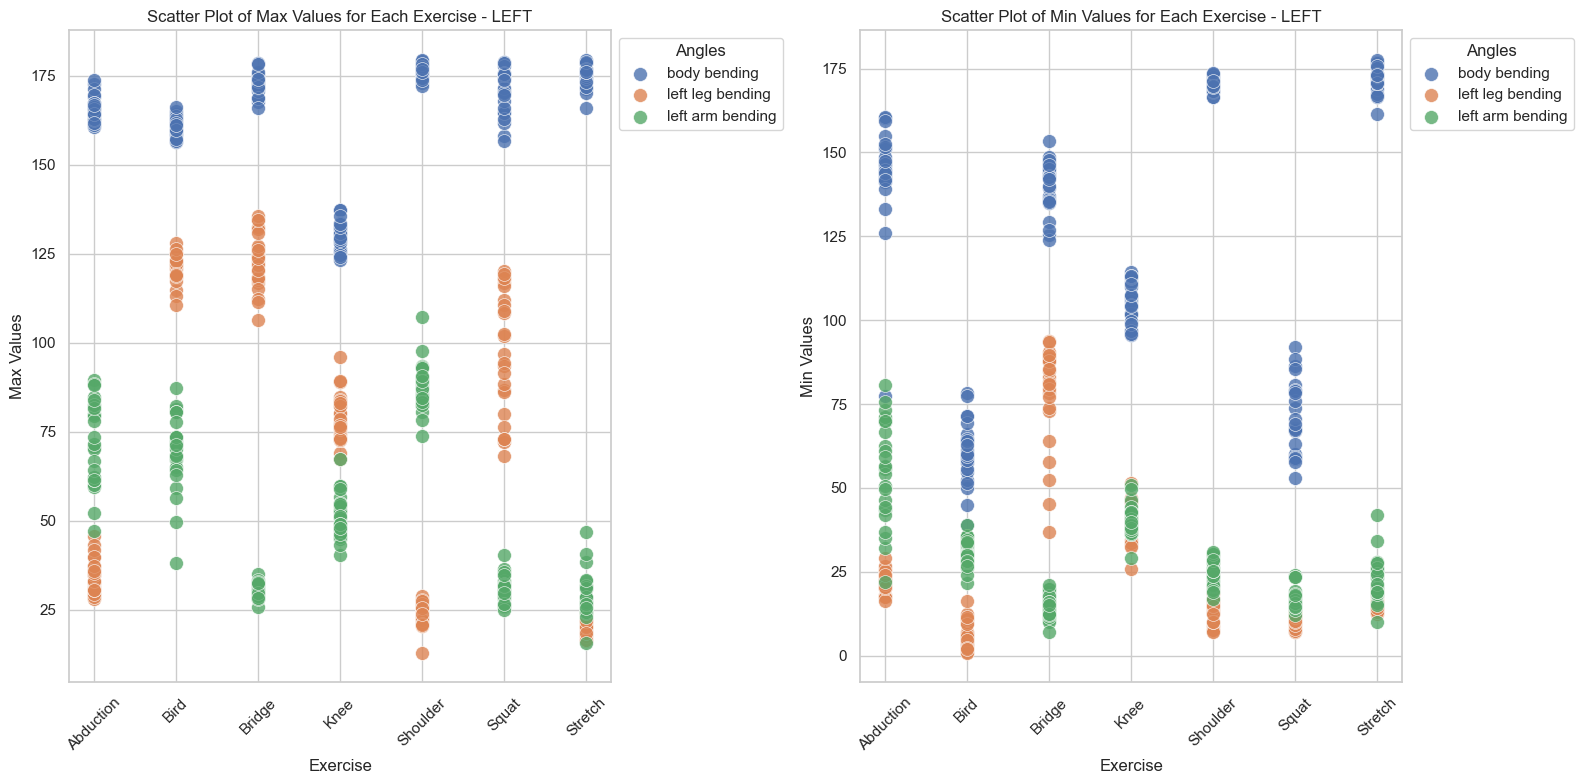

In [47]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), dpi=100, tight_layout=True)

# Scatter plot for Max values
sns.scatterplot(ax=axes[0], x='Exercise', y='Max_angle_left_knee_hip_shoulder',
                data=result_df, s=100, alpha=0.8, edgecolor='w', linewidth=0.5, label='body bending')

sns.scatterplot(ax=axes[0], x='Exercise', y='Max_angle_left_ankle_knee_hip',
                data=result_df, s=100, alpha=0.8, edgecolor='w', linewidth=0.5, label='left leg bending')

sns.scatterplot(ax=axes[0], x='Exercise', y='Max_angle_left_shoulder_elbow_wrist',
                data=result_df, s=100, alpha=0.8, edgecolor='w', linewidth=0.5, label='left arm bending')

axes[0].set_xlabel('Exercise')
axes[0].set_ylabel('Max Values')
axes[0].set_title('Scatter Plot of Max Values for Each Exercise - LEFT')
axes[0].legend(title='Angles', loc='upper left', bbox_to_anchor=(1, 1))
axes[0].tick_params(axis='x', rotation=45)

# Scatter plot for Min values
sns.scatterplot(ax=axes[1], x='Exercise', y='Min_angle_left_knee_hip_shoulder',
                data=result_df, s=100, alpha=0.8, edgecolor='w', linewidth=0.5, label='body bending')

sns.scatterplot(ax=axes[1], x='Exercise', y='Min_angle_left_ankle_knee_hip',
                data=result_df, s=100, alpha=0.8, edgecolor='w', linewidth=0.5, label='left leg bending')

sns.scatterplot(ax=axes[1], x='Exercise', y='Min_angle_left_shoulder_elbow_wrist',
                data=result_df, s=100, alpha=0.8, edgecolor='w', linewidth=0.5, label='left arm bending')

axes[1].set_xlabel('Exercise')
axes[1].set_ylabel('Min Values')
axes[1].set_title('Scatter Plot of Min Values for Each Exercise - LEFT')
axes[1].legend(title='Angles', loc='upper left', bbox_to_anchor=(1, 1))
axes[1].tick_params(axis='x', rotation=45)

# Show the plot
plt.show()


We notice that they are distinct clusters where different participants share similar max and min values and these ranges seem different for each exercise. This distribution could be a way to predict exercises based on which angular range the angle value belongs to. Let us create these ranges : 

In [46]:
table_ranges = max_max_min_min_angles(result_df) # compute the max and min angles over all participants for each exercise
display(table_ranges)

Exercise,Abduction,Bird,Bridge,Knee,Shoulder,Squat,Stretch
Max left body bending,173.963394,166.309418,178.715332,137.351608,179.448563,178.913925,179.499527
Min left body bending,77.363007,39.057140,123.961014,95.698341,166.391098,52.830444,161.454208
Max left leg bending,45.736580,128.077423,135.514557,96.149284,28.934240,120.156982,31.633343
Min left leg bending,16.194044,0.852487,11.612689,25.684669,7.072379,6.932086,12.529250
Max left arm bending,89.444565,87.437698,35.141483,67.219894,107.119904,40.459175,46.810272
Min left arm bending,22.035032,21.610443,7.115463,29.219770,16.998707,12.092675,10.020852
Max right body bending,163.390076,174.578583,174.667023,112.874496,175.748169,167.331619,176.690445
Min right body bending,59.555191,70.915443,116.590027,84.322151,162.934372,44.579834,153.201782
Max right leg bending,128.790634,118.978363,141.673203,104.694984,22.639593,119.824036,131.089462
Min right leg bending,35.205177,17.449335,4.394048,9.608790,2.271933,2.156130,62.595913


We now plot the results of this angular ranges table to visualize more clearly their distribution :

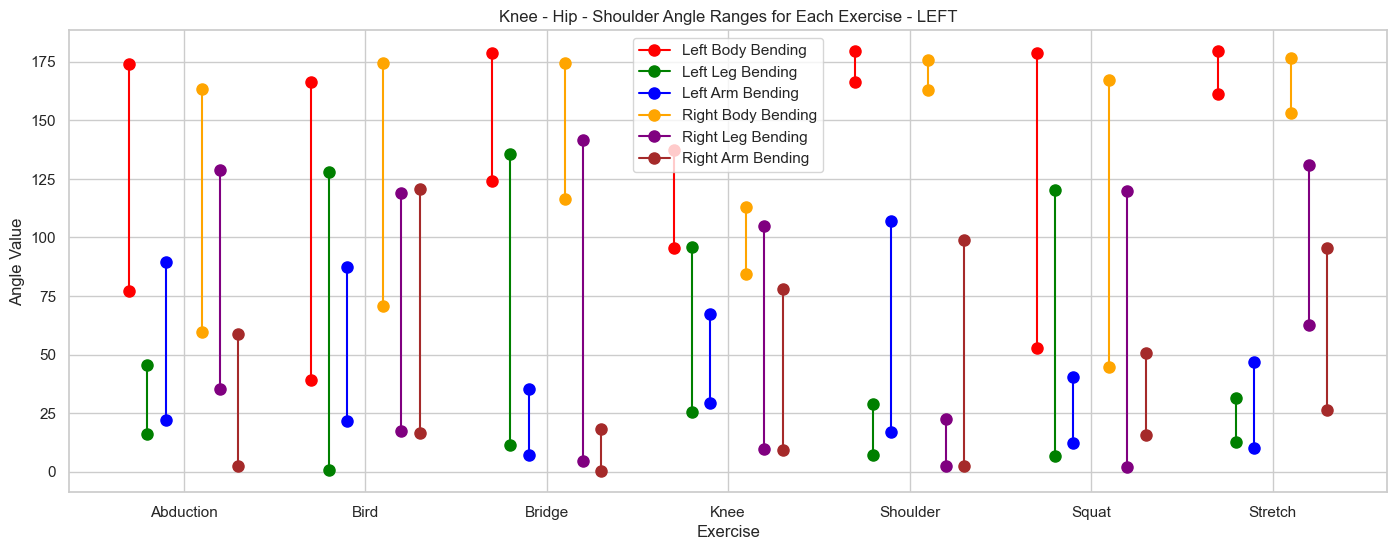

In [84]:
# Data
exercises = ['Abduction', 'Bird', 'Bridge', 'Knee', 'Shoulder', 'Squat', 'Stretch']

max_left_body_bending = table_ranges.iloc[0].values
min_left_body_bending = table_ranges.iloc[1].values
max_left_leg_bending = table_ranges.iloc[2].values
min_left_leg_bending = table_ranges.iloc[3].values
max_left_arm_bending = table_ranges.iloc[4].values
min_left_arm_bending = table_ranges.iloc[5].values
max_right_body_bending = table_ranges.iloc[6].values
min_right_body_bending = table_ranges.iloc[7].values
max_right_leg_bending = table_ranges.iloc[8].values
min_right_leg_bending = table_ranges.iloc[9].values
max_right_arm_bending = table_ranges.iloc[10].values
min_right_arm_bending = table_ranges.iloc[11].values

# Plotting
plt.figure(figsize=(17, 6))  # Increased figure size for better spacing

# Define labels and colors for each set of lines
labels = ['Left Body Bending', 'Left Leg Bending', 'Left Arm Bending', 'Right Body Bending', 'Right Leg Bending', 'Right Arm Bending']
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']

# Lists to store dummy plots for each set of lines
dummy_plots = []

# left body bending
for i, (max_angle, min_angle) in enumerate(zip(max_left_body_bending, min_left_body_bending)):
    line, = plt.plot([i - 0.3, i - 0.3], [max_angle, min_angle], marker='o', markersize=8, color=colors[0])

# Append the dummy plot to the list
dummy_plots.append(line)

# left leg bending
for i, (max_angle, min_angle) in enumerate(zip(max_left_leg_bending, min_left_leg_bending)):
    line, = plt.plot([i - 0.2, i - 0.2], [max_angle, min_angle], marker='o', markersize=8, color=colors[1])

# Append the dummy plot to the list
dummy_plots.append(line)

# left arm bending
for i, (max_angle, min_angle) in enumerate(zip(max_left_arm_bending, min_left_arm_bending)):
    line, = plt.plot([i - 0.1, i - 0.1], [max_angle, min_angle], marker='o', markersize=8, color=colors[2])

# Append the dummy plot to the list
dummy_plots.append(line)

# right body bending
for i, (max_angle, min_angle) in enumerate(zip(max_right_body_bending, min_right_body_bending)):
    line, = plt.plot([i + 0.1, i + 0.1], [max_angle, min_angle], marker='o', markersize=8, color=colors[3])

# Append the dummy plot to the list
dummy_plots.append(line)

# right leg bending
for i, (max_angle, min_angle) in enumerate(zip(max_right_leg_bending, min_right_leg_bending)):
    line, = plt.plot([i + 0.2, i + 0.2], [max_angle, min_angle], marker='o', markersize=8, color=colors[4])

# Append the dummy plot to the list
dummy_plots.append(line)

# right arm bending
for i, (max_angle, min_angle) in enumerate(zip(max_right_arm_bending, min_right_arm_bending)):
    line, = plt.plot([i + 0.3, i + 0.3], [max_angle, min_angle], marker='o', markersize=8, color=colors[5])

# Append the dummy plot to the list
dummy_plots.append(line)

# Adding labels and title
plt.xlabel('Exercise')
plt.ylabel('Angle Value')
plt.title('Knee - Hip - Shoulder Angle Ranges for Each Exercise - LEFT')

# Set custom labels on the x-axis
plt.xticks(np.arange(len(exercises)), exercises)

# Add legends for each set of lines using dummy plots
plt.legend(dummy_plots, labels)

# Show the plot
plt.grid(True)
plt.show()


Looking at the plot, we notice that a large number of ranges are quite wide. This might complicate the accuracy to predict the exercises as a single angle value might belong to many different ranges. 


*For example, a right arm angle of 75° could correspond to 6 different exercises over 7.*

We will still try to predict the exercise based on the angular ranges. We will use the dataset we cut between 50 and 80% of the exercise

In [99]:
columns_approach2 = ['Exercise',
                     'angle_left_knee_hip_shoulder','angle_left_ankle_knee_hip','angle_left_shoulder_elbow_wrist',
                     'angle_right_knee_hip_shoulder','angle_right_ankle_knee_hip','angle_right_shoulder_elbow_wrist'
                     ]

target_data = target_data[columns_approach2]
display(target_data)

,Exercise,angle_left_knee_hip_shoulder,angle_left_ankle_knee_hip,angle_left_shoulder_elbow_wrist,angle_right_knee_hip_shoulder,angle_right_ankle_knee_hip,angle_right_shoulder_elbow_wrist
0,Abduction,161.578568,27.550194,36.858944,154.099350,75.259781,16.272377
1,Abduction,161.466904,27.707176,37.030350,156.676880,72.818184,17.035349
2,Abduction,161.741623,26.751543,37.355446,156.151428,76.745499,15.862656
3,Abduction,161.078522,26.560369,38.315655,156.803802,74.925064,16.389687
4,Abduction,161.086868,26.923771,38.192997,157.959030,74.494743,15.924659
...,...,...,...,...,...,...,...
228072,Stretch,175.493134,18.541292,25.211674,164.325409,117.426918,82.416046
228073,Stretch,175.409225,19.307575,23.777657,164.273041,118.704567,87.279228
228074,Stretch,175.419510,19.404947,23.809711,164.435699,119.145401,81.601479
228075,Stretch,174.637207,19.011559,24.862429,164.025833,118.957886,47.849159


In [129]:
# Example for the first row
exercise_row0 = predict_ex_range(target_data.loc[0], table_ranges)
print(exercise_row0)

Abduction


In [133]:
# Split target_data into X and Y
X = target_data.drop('Exercise', axis=1)  
Y = target_data['Exercise']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Apply the function to predict exercises on the test set
predictions = [predict_ex_range(row, table_ranges) for _, row in X_test.iterrows()]

# Evaluate the accuracy and F1 scores of the predictions
accuracy = accuracy_score(Y_test, predictions)
f1_score_macro = f1_score(Y_test, predictions, average='macro')
f1_score_micro = f1_score(Y_test, predictions, average='micro')

print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'F1 Score macro: {f1_score_macro:.4f}')
print(f'F1 Score micro: {f1_score_micro:.4f}')

Test Accuracy: 54.15%
F1 Score macro: 0.4826
F1 Score micro: 0.5415


We can see that the accuracy is not the best, as angles may cast votes for different exercises as angular ranges are wide. But this approach could be a lead for implementing prediction algorithms based on angles.